# StatsBomb Events JSON Exploration and First Pipeline Tables

**Purpose**

Load one match events JSON, inspect the structure, extract Starting XI information, create basic football visualisations, and convert raw JSON into analysis ready tables as a foundation for an analytics pipeline.

## 1. Load data

In [34]:
import json
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

EVENTS_PATH = Path("events_15946.json")
events = json.loads(EVENTS_PATH.read_text(encoding="utf-8"))

print("Loaded:", EVENTS_PATH.name)
print("Number of events:", len(events))
print("First event keys:", list(events[0].keys()))

Loaded: events_15946.json
Number of events: 3762
First event keys: ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'duration', 'tactics']


## 2. Schema inspection

In [35]:
first_event = events[0]

print("First event type:", first_event["type"]["name"])
print("Team:", first_event.get("team", {}).get("name"))
print("Time (min:sec):", first_event.get("minute"), first_event.get("second"))

event_types = [e.get("type", {}).get("name") for e in events]
event_types = [t for t in event_types if t is not None]

print("\nMost common event types:")
for name, cnt in Counter(event_types).most_common(15):
    print(f"{name}: {cnt}")

First event type: Starting XI
Team: Barcelona
Time (min:sec): 0 0

Most common event types:
Pass: 1163
Ball Receipt*: 1058
Carry: 890
Pressure: 212
Ball Recovery: 89
Duel: 53
Clearance: 37
Goal Keeper: 34
Block: 32
Shot: 28
Interception: 24
Dribble: 24
Foul Committed: 23
Dispossessed: 21
Foul Won: 21


## 3. Starting XI extraction

In [36]:
starting_xi_events = [
    e for e in events
    if e.get("type", {}).get("name") == "Starting XI"
    and e.get("tactics") is not None
    and e["tactics"].get("lineup") is not None
]

print("Starting XI events found:", len(starting_xi_events))

for e in starting_xi_events:
    team_name = e.get("team", {}).get("name")
    formation = e.get("tactics", {}).get("formation")
    lineup_count = len(e.get("tactics", {}).get("lineup", []))
    print(f"{team_name}: {lineup_count} players | formation: {formation}")

barca_xi_event = next(
    (e for e in starting_xi_events if e.get("team", {}).get("name") == "Barcelona"),
    None
)

if barca_xi_event:
    barca_xi = [
        (
            p.get("player", {}).get("name"),
            p.get("position", {}).get("name"),
            p.get("jersey_number")
        )
        for p in barca_xi_event.get("tactics", {}).get("lineup", [])
    ]
    print("\nBarcelona Starting XI:")
    for row in barca_xi:
        print(row)
else:
    print("Barcelona Starting XI not found in this match.")

Starting XI events found: 2
Barcelona: 11 players | formation: 442
Deportivo Alavés: 11 players | formation: 451

Barcelona Starting XI:
('Marc-André ter Stegen', 'Goalkeeper', 1)
('Nélson Cabral Semedo', 'Right Back', 2)
('Gerard Piqué Bernabéu', 'Right Center Back', 3)
('Samuel Yves Umtiti', 'Left Center Back', 23)
('Jordi Alba Ramos', 'Left Back', 18)
('Sergio Busquets i Burgos', 'Right Defensive Midfield', 5)
('Ivan Rakitić', 'Left Defensive Midfield', 4)
('Sergi Roberto Carnicer', 'Right Midfield', 20)
('Ousmane Dembélé', 'Left Midfield', 11)
('Luis Alberto Suárez Díaz', 'Right Center Forward', 9)
('Lionel Andrés Messi Cuccittini', 'Left Center Forward', 10)


## 4. Basic visualisations

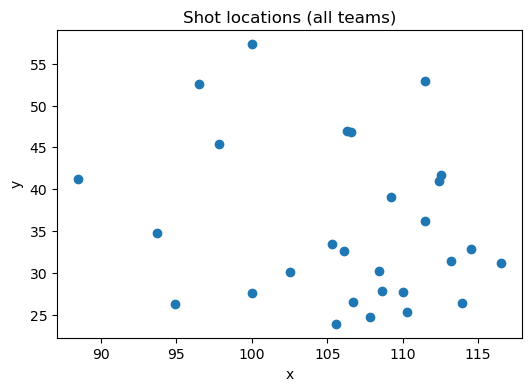

In [37]:
shots = [
    e for e in events
    if e.get("type", {}).get("name") == "Shot"
    and e.get("location") is not None
]

xs = [s["location"][0] for s in shots]
ys = [s["location"][1] for s in shots]

plt.figure(figsize=(6, 4))
plt.scatter(xs, ys)
plt.title("Shot locations (all teams)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

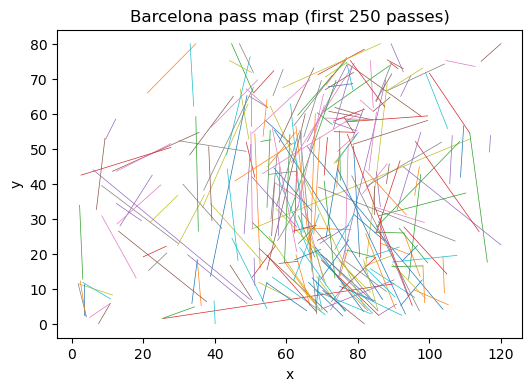

In [38]:
barca_passes = []

for e in events:
    if e.get("type", {}).get("name") != "Pass":
        continue
    if e.get("team", {}).get("name") != "Barcelona":
        continue
    if e.get("location") is None:
        continue

    p = e.get("pass")
    if p is None:
        continue
    end_loc = p.get("end_location")
    if end_loc is None:
        continue

    barca_passes.append(e)

px = [p["location"][0] for p in barca_passes]
py = [p["location"][1] for p in barca_passes]
ex = [p["pass"]["end_location"][0] for p in barca_passes]
ey = [p["pass"]["end_location"][1] for p in barca_passes]

plt.figure(figsize=(6, 4))
for x0, y0, x1, y1 in zip(px[:250], py[:250], ex[:250], ey[:250]):
    plt.plot([x0, x1], [y0, y1], linewidth=0.5)
plt.title("Barcelona pass map (first 250 passes)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

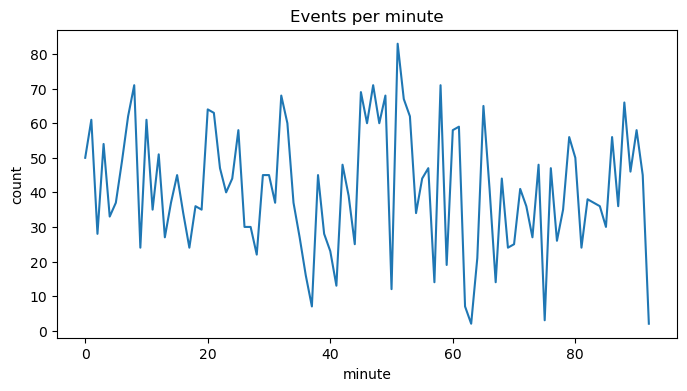

In [39]:
minutes = [e.get("minute") for e in events if e.get("minute") is not None]
counts = Counter(minutes)

plt.figure(figsize=(8, 4))
plt.plot(sorted(counts.keys()), [counts[m] for m in sorted(counts.keys())])
plt.title("Events per minute")
plt.xlabel("minute")
plt.ylabel("count")
plt.show()

## 5. Save outputs

In [41]:
OUTPUTS_DIR = Path("outputs")
OUTPUTS_DIR.mkdir(exist_ok=True)

plt.figure(figsize=(6, 4))
plt.scatter(xs, ys)
plt.title("Shot locations (all teams)")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(OUTPUTS_DIR / "shots_all_teams.png", dpi=200, bbox_inches="tight")
plt.close()

plt.figure(figsize=(6, 4))
for x0, y0, x1, y1 in zip(px[:250], py[:250], ex[:250], ey[:250]):
    plt.plot([x0, x1], [y0, y1], linewidth=0.5)
plt.title("Barcelona pass map (first 250 passes)")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(OUTPUTS_DIR / "barcelona_pass_map.png", dpi=200, bbox_inches="tight")
plt.close()

plt.figure(figsize=(8, 4))
plt.plot(sorted(counts.keys()), [counts[m] for m in sorted(counts.keys())])
plt.title("Events per minute")
plt.xlabel("minute")
plt.ylabel("count")
plt.savefig(OUTPUTS_DIR / "events_per_minute.png", dpi=200, bbox_inches="tight")
plt.close()

print("Plots saved to:", OUTPUTS_DIR.resolve())

Plots saved to: /Users/robparkes/Downloads/outputs


## 6. Data dictionary and analysis ready tables

In [42]:
def safe_get(d, keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k)
        else:
            return default
    return cur if cur is not None else default

rows = []
for e in events:
    loc = e.get("location")
    rows.append({
        "event_id": e.get("id"),
        "index": e.get("index"),
        "period": e.get("period"),
        "timestamp": e.get("timestamp"),
        "minute": e.get("minute"),
        "second": e.get("second"),
        "type": safe_get(e, ["type", "name"]),
        "team": safe_get(e, ["team", "name"]),
        "player": safe_get(e, ["player", "name"]),
        "possession": e.get("possession"),
        "possession_team": safe_get(e, ["possession_team", "name"]),
        "x": loc[0] if isinstance(loc, list) and len(loc) > 0 else None,
        "y": loc[1] if isinstance(loc, list) and len(loc) > 1 else None,
    })

events_basic = pd.DataFrame(rows)
events_basic.head()

,event_id,index,period,timestamp,minute,second,type,team,player,possession,possession_team,x,y
0,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,00:00:00.000,0,0,Starting XI,Barcelona,None,1,Barcelona,NaN,NaN
1,0300039d-150d-41e4-b29a-76602ef002e6,2,1,00:00:00.000,0,0,Starting XI,Deportivo Alavés,None,1,Barcelona,NaN,NaN
2,491e8901-7630-4cc8-b57b-937dddff2eaa,3,1,00:00:00.000,0,0,Half Start,Barcelona,None,1,Barcelona,NaN,NaN
3,757b85ad-ddfe-44d5-b893-c23a9fb709d8,4,1,00:00:00.000,0,0,Half Start,Deportivo Alavés,None,1,Barcelona,NaN,NaN
4,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,5,1,00:00:00.575,0,0,Pass,Deportivo Alavés,Jonathan Rodríguez Menéndez,2,Deportivo Alavés,61.0,40.1


In [43]:
pass_rows = []
for e in events:
    if safe_get(e, ["type", "name"]) != "Pass":
        continue

    start_loc = e.get("location")
    p = e.get("pass") or {}
    end_loc = p.get("end_location")

    pass_rows.append({
        "event_id": e.get("id"),
        "minute": e.get("minute"),
        "second": e.get("second"),
        "team": safe_get(e, ["team", "name"]),
        "player": safe_get(e, ["player", "name"]),
        "recipient": safe_get(p, ["recipient", "name"]),
        "start_x": start_loc[0] if isinstance(start_loc, list) and len(start_loc) > 0 else None,
        "start_y": start_loc[1] if isinstance(start_loc, list) and len(start_loc) > 1 else None,
        "end_x": end_loc[0] if isinstance(end_loc, list) and len(end_loc) > 0 else None,
        "end_y": end_loc[1] if isinstance(end_loc, list) and len(end_loc) > 1 else None,
        "outcome": safe_get(p, ["outcome", "name"]),
        "length": p.get("length"),
        "angle": p.get("angle"),
        "height": safe_get(p, ["height", "name"]),
    })

passes_df = pd.DataFrame(pass_rows)
passes_df.head()

,event_id,minute,second,team,player,recipient,start_x,start_y,end_x,end_y,outcome,length,angle,height
0,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,0,0,Deportivo Alavés,Jonathan Rodríguez Menéndez,Guillermo Alfonso Maripán Loaysa,61.0,40.1,33.8,28.0,None,29.769950,-2.723027,Ground Pass
1,4e4e4cad-9897-43ec-842d-585a4077f6ce,0,3,Deportivo Alavés,Guillermo Alfonso Maripán Loaysa,Rubén Sobrino Pozuelo,36.8,27.3,86.5,74.2,Incomplete,68.335205,0.756421,High Pass
2,be27cc25-92b5-4696-b43c-aad957a6119a,0,7,Barcelona,Sergio Busquets i Burgos,Ivan Rakitić,33.6,5.9,35.1,18.3,None,12.490396,1.450414,High Pass
3,b33c0b7f-7456-4efe-b43c-5fd7cbd14689,0,8,Barcelona,Ivan Rakitić,Ousmane Dembélé,35.1,18.3,36.2,5.3,None,13.046455,-1.486382,High Pass
4,c587e5ce-fe6e-4cfb-b510-8a8e193699d3,0,10,Barcelona,Ousmane Dembélé,Jordi Alba Ramos,34.3,4.9,25.3,1.6,None,9.585927,-2.790148,Ground Pass


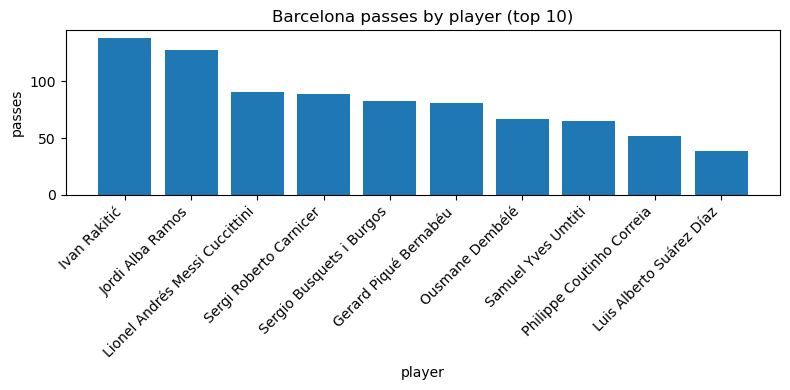

In [44]:
barca_passes_df = passes_df[passes_df["team"] == "Barcelona"]

top_players = barca_passes_df["player"].value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.bar(top_players.index, top_players.values)
plt.xticks(rotation=45, ha="right")
plt.title("Barcelona passes by player (top 10)")
plt.xlabel("player")
plt.ylabel("passes")
plt.tight_layout()
plt.show()

## 4. Pipeline input concepts and minimum fields

This section defines what the input to the pipeline looks like and the minimum fields needed to convert raw JSON into analysis ready tables.

### Core concepts
Match metadata  
A match is identified by match_id and basic context such as teams and competition information. In this notebook, the match_id is inferred from the filename.

Event level data  
The events file is a list of event objects. One event corresponds to one action or state change within the match (for example pass, shot, duel, or a Starting XI entry).

Entity identifiers  
Teams and players are represented using nested objects containing both id and name. These ids allow consistent linking across tables.

### Minimum fields used in tables
Match context  
match_id, period, minute, second, timestamp

Event basics  
event_id, type, team, player, location_x, location_y, possession, possession_team

Pass fields  
start_x, start_y, end_x, end_y, outcome, length, angle, height, recipient

Shot fields  
shot_outcome, shot_xg if available, shot_end_location if available

In [45]:
def safe_get(d, keys, default=None):
    cur = d
    for k in keys:
        if cur is None:
            return default
        if isinstance(cur, dict):
            cur = cur.get(k)
        else:
            return default
    return cur if cur is not None else default

In [46]:
match_id = 15946  # set manually based on filename

rows = []
for e in events:
    loc = e.get("location")
    rows.append({
        "match_id": match_id,
        "event_id": e.get("id"),
        "index": e.get("index"),
        "period": e.get("period"),
        "timestamp": e.get("timestamp"),
        "minute": e.get("minute"),
        "second": e.get("second"),
        "type": safe_get(e, ["type", "name"]),
        "team": safe_get(e, ["team", "name"]),
        "team_id": safe_get(e, ["team", "id"]),
        "player": safe_get(e, ["player", "name"]),
        "player_id": safe_get(e, ["player", "id"]),
        "possession": e.get("possession"),
        "possession_team": safe_get(e, ["possession_team", "name"]),
        "possession_team_id": safe_get(e, ["possession_team", "id"]),
        "x": loc[0] if isinstance(loc, list) and len(loc) > 0 else None,
        "y": loc[1] if isinstance(loc, list) and len(loc) > 1 else None,
    })

events_basic = pd.DataFrame(rows)
events_basic.head()

,match_id,event_id,index,period,timestamp,minute,second,type,team,team_id,player,player_id,possession,possession_team,possession_team_id,x,y
0,15946,9f6e2ecf-6685-45df-a62e-c2db3090f6c1,1,1,00:00:00.000,0,0,Starting XI,Barcelona,217,None,NaN,1,Barcelona,217,NaN,NaN
1,15946,0300039d-150d-41e4-b29a-76602ef002e6,2,1,00:00:00.000,0,0,Starting XI,Deportivo Alavés,206,None,NaN,1,Barcelona,217,NaN,NaN
2,15946,491e8901-7630-4cc8-b57b-937dddff2eaa,3,1,00:00:00.000,0,0,Half Start,Barcelona,217,None,NaN,1,Barcelona,217,NaN,NaN
3,15946,757b85ad-ddfe-44d5-b893-c23a9fb709d8,4,1,00:00:00.000,0,0,Half Start,Deportivo Alavés,206,None,NaN,1,Barcelona,217,NaN,NaN
4,15946,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,5,1,00:00:00.575,0,0,Pass,Deportivo Alavés,206,Jonathan Rodríguez Menéndez,6581.0,2,Deportivo Alavés,206,61.0,40.1


In [47]:
print("events_basic shape:", events_basic.shape)
events_basic["type"].value_counts().head(10)

events_basic shape: (3762, 17)


type
Pass             1163
Ball Receipt*    1058
Carry             890
Pressure          212
Ball Recovery      89
Duel               53
Clearance          37
Goal Keeper        34
Block              32
Shot               28
Name: count, dtype: int64

In [48]:
pass_rows = []
for e in events:
    if safe_get(e, ["type", "name"]) != "Pass":
        continue

    start_loc = e.get("location")
    p = e.get("pass") or {}
    end_loc = p.get("end_location")

    pass_rows.append({
        "match_id": match_id,
        "event_id": e.get("id"),
        "minute": e.get("minute"),
        "second": e.get("second"),
        "team": safe_get(e, ["team", "name"]),
        "team_id": safe_get(e, ["team", "id"]),
        "player": safe_get(e, ["player", "name"]),
        "player_id": safe_get(e, ["player", "id"]),
        "recipient": safe_get(p, ["recipient", "name"]),
        "recipient_id": safe_get(p, ["recipient", "id"]),
        "start_x": start_loc[0] if isinstance(start_loc, list) and len(start_loc) > 0 else None,
        "start_y": start_loc[1] if isinstance(start_loc, list) and len(start_loc) > 1 else None,
        "end_x": end_loc[0] if isinstance(end_loc, list) and len(end_loc) > 0 else None,
        "end_y": end_loc[1] if isinstance(end_loc, list) and len(end_loc) > 1 else None,
        "outcome": safe_get(p, ["outcome", "name"]),
        "length": p.get("length"),
        "angle": p.get("angle"),
        "height": safe_get(p, ["height", "name"]),
        "body_part": safe_get(p, ["body_part", "name"]),
        "pass_type": safe_get(p, ["type", "name"]),
    })

passes_df = pd.DataFrame(pass_rows)
passes_df.head()

,match_id,event_id,minute,second,team,team_id,player,player_id,recipient,recipient_id,start_x,start_y,end_x,end_y,outcome,length,angle,height,body_part,pass_type
0,15946,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,0,0,Deportivo Alavés,206,Jonathan Rodríguez Menéndez,6581,Guillermo Alfonso Maripán Loaysa,6855.0,61.0,40.1,33.8,28.0,None,29.769950,-2.723027,Ground Pass,Left Foot,Kick Off
1,15946,4e4e4cad-9897-43ec-842d-585a4077f6ce,0,3,Deportivo Alavés,206,Guillermo Alfonso Maripán Loaysa,6855,Rubén Sobrino Pozuelo,6613.0,36.8,27.3,86.5,74.2,Incomplete,68.335205,0.756421,High Pass,Right Foot,None
2,15946,be27cc25-92b5-4696-b43c-aad957a6119a,0,7,Barcelona,217,Sergio Busquets i Burgos,5203,Ivan Rakitić,5470.0,33.6,5.9,35.1,18.3,None,12.490396,1.450414,High Pass,None,Recovery
3,15946,b33c0b7f-7456-4efe-b43c-5fd7cbd14689,0,8,Barcelona,217,Ivan Rakitić,5470,Ousmane Dembélé,5477.0,35.1,18.3,36.2,5.3,None,13.046455,-1.486382,High Pass,Head,None
4,15946,c587e5ce-fe6e-4cfb-b510-8a8e193699d3,0,10,Barcelona,217,Ousmane Dembélé,5477,Jordi Alba Ramos,5211.0,34.3,4.9,25.3,1.6,None,9.585927,-2.790148,Ground Pass,Right Foot,None


In [49]:
print("passes_df shape:", passes_df.shape)
passes_df["team"].value_counts().head(10), passes_df["outcome"].value_counts(dropna=False).head(10)

passes_df shape: (1163, 20)


(team
 Barcelona           917
 Deportivo Alavés    246
 Name: count, dtype: int64,
 outcome
 None                984
 Incomplete          150
 Out                  21
 Unknown               4
 Pass Offside          3
 Injury Clearance      1
 Name: count, dtype: int64)

In [50]:
from pathlib import Path

OUTPUTS_DIR = Path("outputs")
OUTPUTS_DIR.mkdir(exist_ok=True)

events_basic_path = OUTPUTS_DIR / "events_basic_15946.csv"
passes_path = OUTPUTS_DIR / "passes_15946.csv"

events_basic.to_csv(events_basic_path, index=False)
passes_df.to_csv(passes_path, index=False)

print("Saved:", events_basic_path)
print("Saved:", passes_path)

Saved: outputs/events_basic_15946.csv
Saved: outputs/passes_15946.csv


## 4. Simple check metric

As a simple validation that the pass table is usable, calculate Barcelona passes by player.

In [52]:
barca_passes = passes_df[passes_df["team"] == "Barcelona"]
barca_passes["player"].value_counts().head(15)

player
Ivan Rakitić                              138
Jordi Alba Ramos                          128
Lionel Andrés Messi Cuccittini             91
Sergi Roberto Carnicer                     89
Sergio Busquets i Burgos                   83
Gerard Piqué Bernabéu                      81
Ousmane Dembélé                            67
Samuel Yves Umtiti                         65
Philippe Coutinho Correia                  52
Luis Alberto Suárez Díaz                   39
Nélson Cabral Semedo                       32
Marc-André ter Stegen                      27
Arthur Henrique Ramos de Oliveira Melo     18
Arturo Erasmo Vidal Pardo                   7
Name: count, dtype: int64

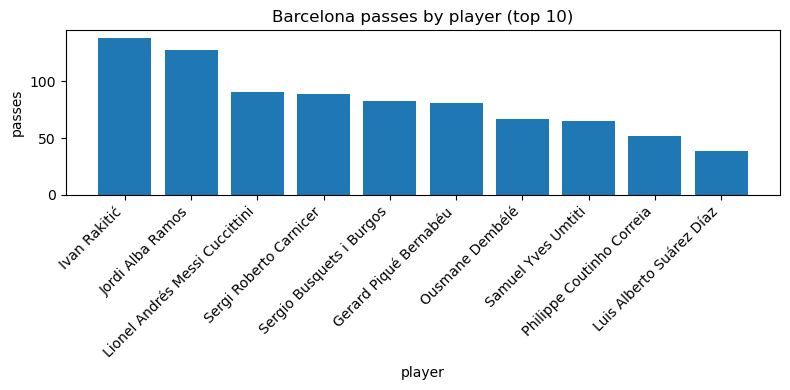

In [54]:
import matplotlib.pyplot as plt

top = barca_passes["player"].value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.bar(top.index, top.values)
plt.xticks(rotation=45, ha="right")
plt.title("Barcelona passes by player (top 10)")
plt.xlabel("player")
plt.ylabel("passes")
plt.tight_layout()
plt.show()

In [55]:
plt.figure(figsize=(8, 4))
plt.bar(top.index, top.values)
plt.xticks(rotation=45, ha="right")
plt.title("Barcelona passes by player (top 10)")
plt.xlabel("player")
plt.ylabel("passes")
plt.tight_layout()
plt.savefig(OUTPUTS_DIR / "barcelona_passes_top10.png", dpi=200, bbox_inches="tight")
plt.close()

print("Saved:", OUTPUTS_DIR / "barcelona_passes_top10.png")

Saved: outputs/barcelona_passes_top10.png
